In [32]:
# Setting Arguments
args_text = '--base-model sentence-transformers/paraphrase-MiniLM-L6-v2 '+\
            '--dataset news --n-word 2000 --epochs-1 100 --epochs-2 50 ' + \
            '--bsz 32 --stage-2-lr 2e-2 --stage-2-repeat 5 --coeff-1-dist 50 '+ \
            '--n-cluster 20 ' + \
            '--stage-1-ckpt trained_model/news_model_paraphrase-MiniLM-L6-v2_stage1_20t_2000w_99e.ckpt'

In [ ]:
import re
import os
import sys
import time
import copy
import math
import argparse
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtools.optim import RangerLars
import gensim.downloader
import itertools

from scipy.stats import ortho_group
from scipy.optimize import linear_sum_assignment as linear_assignment
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

import numpy as np
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from utils import AverageMeter
from collections import OrderedDict

import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from gensim.corpora.dictionary import Dictionary
from pytorch_transformers import *
from sklearn.mixture import GaussianMixture
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from nltk.corpus import stopwords

from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
import scipy.sparse as sp
import nltk
from nltk.corpus import stopwords

from datetime import datetime
from itertools import combinations
import gensim.downloader
from scipy.linalg import qr
from data import *
from model import ContBertTopicExtractorAE
from evaluation import get_topic_qualities
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2,3" 

# Data loading

In [5]:
def _parse_args():
    parser = argparse.ArgumentParser(description='Contrastive topic modeling')
    parser.add_argument('--epochs-1', default=100, type=int,
                        help='Number of training epochs for Stage 1')
    parser.add_argument('--epochs-2', default=10, type=int,
                        help='Number of training epochs for Stage 2')
    parser.add_argument('--bsz', type=int, default=64,
                        help='Batch size')
    parser.add_argument('--dataset', default='news', type=str,
                        choices=['news', 'twitter', 'wiki', 'nips', 'stackoverflow', 'reuters', 'r52'],
                        help='Name of the dataset')
    parser.add_argument('--n-cluster', default=20, type=int,
                        help='Number of clusters')
    parser.add_argument('--n-topic', type=int,
                        help='Number of topics. If not specified, use same value as --n-cluster')
    parser.add_argument('--n-word', default=2000, type=int,
                        help='Number of words in vocabulary')
    
    parser.add_argument('--base-model', type=str,
                        help='Name of base model in huggingface library.')
    
    parser.add_argument('--gpus', default=[0,1,2,3], type=int, nargs='+',
                        help='List of GPU numbers to use. Use 0 by default')
    
    parser.add_argument('--coeff-1-sim', default=1.0, type=float,
                        help='Coefficient for NN dot product similarity loss (Phase 1)')
    parser.add_argument('--coeff-1-dist', default=1.0, type=float,
                        help='Coefficient for NN SWD distribution loss (Phase 1)')
    parser.add_argument('--dirichlet-alpha-1', type=float,
                        help='Parameter for Dirichlet distribution (Phase 1). Use 1/n_topic by default.')
    
    parser.add_argument('--stage-1-ckpt', type=str,
                        help='Name of torch checkpoint file Stage 1. If this argument is given, skip Stage 1.')
    
    parser.add_argument('--coeff-2-recon', default=1.0, type=float,
                        help='Coefficient for VAE reconstruction loss (Phase 2)')
    parser.add_argument('--coeff-2-regul', default=1.0, type=float,
                        help='Coefficient for VAE KLD regularization loss (Phase 2)')
    parser.add_argument('--coeff-2-cons', default=1.0, type=float,
                        help='Coefficient for CL consistency loss (Phase 2)')
    parser.add_argument('--coeff-2-dist', default=1.0, type=float,
                        help='Coefficient for CL SWD distribution matching loss (Phase 2)')
    parser.add_argument('--dirichlet-alpha-2', type=float,
                        help='Parameter for Dirichlet distribution (Phase 2). Use same value as dirichlet-alpha-1 by default.')
    
    parser.add_argument('--stage-2-lr', default=2e-1, type=float,
                        help='Learning rate of phase 2')
    parser.add_argument('--stage-2-repeat', default=5, type=int,
                        help='Repetition count of phase 2')
    
    parser.add_argument('--result-file', type=str,
                        help='File name for result summary')
    parser.add_argument('--palmetto-dir', type=str,
                        help='Directory where palmetto JAR and the Wikipedia index are. For evaluation')
    
    
    # Check if the code is run in Jupyter notebook
    is_in_jupyter = False
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            is_in_jupyter = True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            is_in_jupyter = False  # Terminal running IPython
        else:
            is_in_jupyter = False  # Other type (?)
    except NameError:
        is_in_jupyter = False
    
    if is_in_jupyter:
        return parser.parse_args(args=args_text.split())
    else:
        return parser.parse_args()

def data_load(dataset_name):
    should_measure_hungarian = False
    if dataset_name == 'news':
        textData = newsData()
        should_measure_hungarian = True
    elif args.dataset == 'twitter':
        textData = twitterData('/home/data/topicmodel/twitter_covid19.tsv')
    elif args.dataset == 'wiki':
        textData = wikiData('/home/data/topicmodel/smplAbstracts/')
    elif args.dataset == 'nips':
        textData = nipsData('/home/data/topicmodel/papers.csv')
    elif args.dataset == 'stackoverflow':
        textData = stackoverflowData('/home/data/topicmodel/stack_overflow.csv')
    elif args.dataset == 'reuters':
        textData = reutersData('/home/data/topicmodel/reuters-21578.txt')
    elif args.dataset == 'r52':
        textData = r52Data('/home/data/topicmodel/r52/')
        should_measure_hungarian = True
    return textData, should_measure_hungarian

In [6]:
args = _parse_args()
bsz = args.bsz
epochs_1 = args.epochs_1
epochs_2 = args.epochs_2

n_cluster = args.n_cluster
n_topic = args.n_topic if (args.n_topic is not None) else n_cluster
args.n_topic = n_topic

textData, should_measure_hungarian = data_load(args.dataset)

ema_alpha = 0.99
n_word = args.n_word
if args.dirichlet_alpha_1 is None:
    dirichlet_alpha_1 = 1 / n_cluster
else:
    dirichlet_alpha_1 = args.dirichlet_alpha_1
if args.dirichlet_alpha_2 is None:
    dirichlet_alpha_2 = dirichlet_alpha_1
else:
    dirichlet_alpha_2 = args.dirichlet_alpha_2
    
bert_name = args.base_model
bert_name_short = bert_name.split('/')[-1]
gpu_ids = args.gpus

skip_stage_1 = (args.stage_1_ckpt is not None)

In [7]:
trainds = BertDataset(bert=bert_name, text_list=textData.data, N_word=n_word, vectorizer=None, lemmatize=True)
basesim_path = f"./save/{args.dataset}_{bert_name_short}_basesim_matrix_full.pkl"
if os.path.isfile(basesim_path) == False:
    model = SentenceTransformer(bert_name.split('/')[-1], device='cuda')
    base_result_list = []
    for text in tqdm_notebook(trainds.nonempty_text):
        base_result_list.append(model.encode(text))
        
    base_result_embedding = np.stack(base_result_list)
    basereduced_norm = F.normalize(torch.tensor(base_result_embedding), dim=-1)
    basesim_matrix = torch.mm(basereduced_norm, basereduced_norm.t())
    ind = np.diag_indices(basesim_matrix.shape[0])
    basesim_matrix[ind[0], ind[1]] = torch.ones(basesim_matrix.shape[0]) * -1
    torch.save(basesim_matrix, basesim_path)
else:
    basesim_matrix = torch.load(basesim_path)

100%|██████████| 11096/11096 [00:17<00:00, 651.95it/s]


# Step 1: Discovery neighborhood pairs and clustering

In [8]:
def dist_match_loss(hidden, alpha=1.0):
    device = hidden.device
    hidden_dim = hidden.shape[-1]
    rand_w = torch.Tensor(np.eye(hidden_dim, dtype=np.float64)).to(device)
    loss_dist_match = get_swd_loss(hidden, rand_w, alpha)
    return loss_dist_match


def get_swd_loss(states, rand_w, alpha=1.0):
    device = states.device
    states_shape = states.shape
    states = torch.matmul(states, rand_w)
    states_t, _ = torch.sort(states.t(), dim=1)

    states_prior = torch.Tensor(np.random.dirichlet([alpha]*states_shape[1], states_shape[0])).to(device) # (bsz, dim)
    states_prior = torch.matmul(states_prior, rand_w) # (dim, dim)
    states_prior_t, _ = torch.sort(states_prior.t(), dim=1) # (dim, bsz)
    return torch.mean(torch.sum((states_prior_t - states_t) ** 2, axis=0))


def _hungarian_match(flat_preds, flat_targets, num_samples, class_num):  
    num_k = class_num
    num_correct = np.zeros((num_k, num_k))
  
    for c1 in range(0, num_k):
        for c2 in range(0, num_k):
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes
  
    match = linear_assignment(num_samples - num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
  
    return res

In [9]:
try:
    del model
except:
    pass
finally:
    torch.cuda.empty_cache()

In [10]:
if not skip_stage_1:
    model = ContBertTopicExtractorAE(N_topic=n_cluster, N_word=n_word, bert=bert_name, bert_dim=768)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model, device_ids=gpu_ids)
    model.cuda(gpu_ids[0])

In [11]:
bsz = args.bsz = 128

In [12]:
if not skip_stage_1:
    losses = AverageMeter()
    closses = AverageMeter() 
    dlosses = AverageMeter() 
    rlosses = AverageMeter() 
    criterion = nn.CrossEntropyLoss()

    temp_basesim_matrix = copy.deepcopy(basesim_matrix)
    finetuneds = FinetuneDataset(trainds, temp_basesim_matrix, ratio=1, k=1)
    trainloader = DataLoader(finetuneds, batch_size=bsz, shuffle=True, num_workers=0)
    memoryloader = DataLoader(finetuneds, batch_size=bsz * 2, shuffle=False, num_workers=0)

    optimizer = RangerLars(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    global_step = 0
    memory_queue = F.softmax(torch.randn(512, n_cluster).cuda(gpu_ids[0]), dim=1)
    for epoch in range(epochs_1):
        model.train()
        #ema_model.train()
        tbar = tqdm_notebook(trainloader)
        for batch_idx, batch in enumerate(tbar):       
            org_input, pos_input, _, _ = batch
            org_input_ids = org_input['input_ids'].cuda(gpu_ids[0])
            org_attention_mask = org_input['attention_mask'].cuda(gpu_ids[0])
            pos_input_ids = pos_input['input_ids'].cuda(gpu_ids[0])
            pos_attention_mask = pos_input['attention_mask'].cuda(gpu_ids[0])
            batch_size = org_input_ids.size(0)

            all_input_ids = torch.cat((org_input_ids, pos_input_ids), dim=0)
            all_attention_masks = torch.cat((org_attention_mask, pos_attention_mask), dim=0)
            all_topics, _ = model(all_input_ids, all_attention_masks, return_topic=True)

            orig_topic, pos_topic = torch.split(all_topics, len(all_topics) // 2)
            pos_sim = torch.sum(orig_topic * pos_topic, dim=-1)

            # consistency loss
            consistency_loss = -pos_sim.mean()

            # distribution matching loss
            memory_queue = torch.cat((memory_queue.detach(), all_topics), dim=0)[all_topics.size(0):]
            distmatch_loss = dist_match_loss(memory_queue, dirichlet_alpha_1)
            loss = args.coeff_1_sim * consistency_loss + \
                   10 * distmatch_loss

            losses.update(loss.item(), bsz)
            closses.update(consistency_loss.item(), bsz)
            dlosses.update(distmatch_loss.item(), bsz)

            tbar.set_description("Epoch-{} / consistency: {:.5f} - dist: {:.5f}".format(epoch, 
                                                                                        closses.avg, 
                                                                                        dlosses.avg), refresh=True)
            tbar.refresh()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            global_step += 1
        scheduler.step()
        
#         model.eval()
#         result_list = []
#         with torch.no_grad():
#             for idx, batch in enumerate(tqdm_notebook(memoryloader)):        
#                 org_input, _, _, _ = batch
#                 org_input_ids = org_input['input_ids'].cuda(gpu_ids[0])
#                 org_attention_mask = org_input['attention_mask'].cuda(gpu_ids[0])
#                 topic, _ = model(org_input_ids, org_attention_mask, return_topic = True)
#                 result_list.append(topic)
#         result_embedding = torch.cat(result_list)
#         _, result_topic = torch.max(result_embedding, 1)
    
#         flat_predict = result_topic
#         flat_target = torch.tensor(textData.target_filtered).to(flat_predict.device)
#         num_samples = flat_predict.shape[0]
#         match = _hungarian_match(flat_predict, flat_target, num_samples, 20)    
#         reordered_preds = torch.zeros(num_samples).to(flat_predict.device)
#         for pred_i, target_i in match:
#             reordered_preds[flat_predict == pred_i] = int(target_i)
#         acc = int((reordered_preds == flat_target.float()).sum()) / float(num_samples) * 100
#         print(acc)
        
#         points = []
#         for i in range(1, n_topic+1):
#             points.append([math.cos(math.radians(360 / n_topic * i)), math.sin(math.radians(360 / n_topic * i))])
#         points = torch.Tensor(np.array(points))
#         numpy_points = torch.mm(result_embedding.detach().cpu(), points).numpy()

#         plt.figure(figsize=(10, 10))
#         plt.axis('off')
#         try:
#             color_map = textData.target_filtered.tolist()
#             plt.scatter(numpy_points[:, 0], numpy_points[:, 1], c = color_map, cmap = plt.cm.rainbow, s=1)
#         except:
#             plt.scatter(numpy_points[:, 0], numpy_points[:, 1], cmap = plt.cm.rainbow, s=1)
#         plt.show()

In [13]:
if not skip_stage_1:
    model_stage1_name = f'./trained_model/{args.dataset}_model_{bert_name_short}_stage1_{args.n_topic}t_{args.n_word}w_{epoch}e.ckpt'
    torch.save(model.module.state_dict(), model_stage1_name)
else:
    model_stage1_name = args.stage_1_ckpt

In [ ]:
model.eval()
result_list = []
with torch.no_grad():
    for idx, batch in enumerate(tqdm_notebook(memoryloader)):        
        org_input, _, _, _ = batch
        org_input_ids = org_input['input_ids'].cuda(gpu_ids[0])
        org_attention_mask = org_input['attention_mask'].cuda(gpu_ids[0])
        topic, _ = model(org_input_ids, org_attention_mask, return_topic = True)
        result_list.append(topic)
result_embedding = torch.cat(result_list)
_, result_topic = torch.max(result_embedding, 1)

In [15]:
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from gensim.utils import deaccent
from nltk.corpus import stopwords as stop_words

def _hungarian_match(flat_preds, flat_targets, num_samples, class_num):  
    num_k = class_num
    num_correct = np.zeros((num_k, num_k))
  
    for c1 in range(0, num_k):
        for c2 in range(0, num_k):
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes
  
    match = linear_assignment(num_samples - num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
  
    return res


class WhiteSpacePreprocessing():
    def __init__(self, documents, stopwords_language="english", vocabulary_size=2000):
        self.documents = documents
        self.stopwords = set(stop_words.words(stopwords_language))
        self.vocabulary_size = vocabulary_size

        warnings.simplefilter('always', DeprecationWarning)
        warnings.warn("WhiteSpacePreprocessing is deprecated and will be removed in future versions."
                      "Use WhiteSpacePreprocessingStopwords.")

    def preprocess(self):
        preprocessed_docs_tmp = self.documents
        preprocessed_docs_tmp = [deaccent(doc.lower()) for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [doc.translate(
            str.maketrans(string.punctuation, ' ' * len(string.punctuation))) for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if len(w) > 0 and w not in self.stopwords])
                                 for doc in preprocessed_docs_tmp]

        vectorizer = CountVectorizer(max_features=self.vocabulary_size)
        vectorizer.fit_transform(preprocessed_docs_tmp)
        temp_vocabulary = set(vectorizer.get_feature_names())

        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w in temp_vocabulary])
                                 for doc in preprocessed_docs_tmp]

        preprocessed_docs, unpreprocessed_docs, retained_indices = [], [], []
        for i, doc in enumerate(preprocessed_docs_tmp):
            if len(doc) > 0:
                preprocessed_docs.append(doc)
                unpreprocessed_docs.append(self.documents[i])
                retained_indices.append(i)

        vocabulary = list(set([item for doc in preprocessed_docs for item in doc.split()]))

        return preprocessed_docs, unpreprocessed_docs, vocabulary, retained_indices


class TopicModelDataPreparationNoNumber(TopicModelDataPreparation):
    def fit(self, text_for_contextual, text_for_bow, labels=None, wordlist=None):
        """
        This method fits the vectorizer and gets the embeddings from the contextual model
        :param text_for_contextual: list of unpreprocessed documents to generate the contextualized embeddings
        :param text_for_bow: list of preprocessed documents for creating the bag-of-words
        :param labels: list of labels associated with each document (optional).
        """

        if self.contextualized_model is None:
            raise Exception("You should define a contextualized model if you want to create the embeddings")

        # TODO: this count vectorizer removes tokens that have len = 1, might be unexpected for the users
        self.vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z]{2,}\b', vocabulary=wordlist)

        train_bow_embeddings = self.vectorizer.fit_transform(text_for_bow)
        train_contextualized_embeddings = bert_embeddings_from_list(text_for_contextual, self.contextualized_model)
        self.vocab = self.vectorizer.get_feature_names()
        self.id2token = {k: v for k, v in zip(range(0, len(self.vocab)), self.vocab)}

        if labels:
            self.label_encoder = OneHotEncoder()
            encoded_labels = self.label_encoder.fit_transform(np.array([labels]).reshape(-1, 1))
        else:
            encoded_labels = None

        return CTMDataset(train_contextualized_embeddings, train_bow_embeddings, self.id2token, encoded_labels)


In [38]:
qt = TopicModelDataPreparationNoNumber("sentence-transformers/paraphrase-MiniLM-L6-v2")
sp = WhiteSpacePreprocessing(textData.data, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab, retained_labels = sp.preprocess()

In [ ]:
train_target_filtered = textData.targets.values.squeeze()[retained_labels]

17.857142857142858


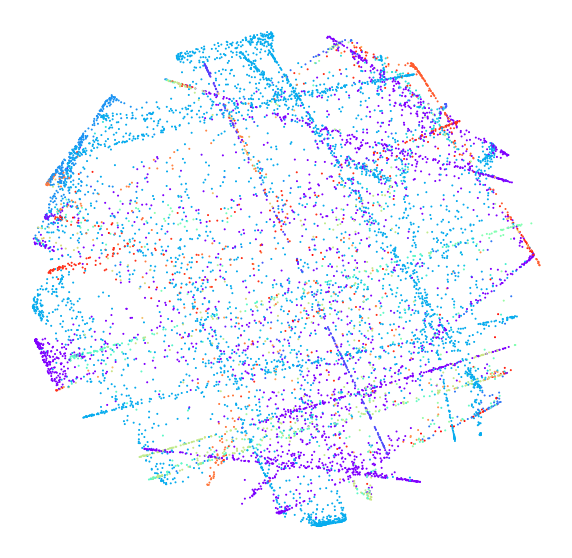

In [38]:
flat_predict = result_topic
flat_target = torch.tensor(train_target_filtered).to(flat_predict.device)
num_samples = flat_predict.shape[0]
match = _hungarian_match(flat_predict, flat_target, num_samples, 52)    
reordered_preds = torch.zeros(num_samples).to(flat_predict.device)
for pred_i, target_i in match:
    reordered_preds[flat_predict == pred_i] = int(target_i)
acc = int((reordered_preds == flat_target.float()).sum()) / float(num_samples) * 100
print(acc)

points = []
for i in range(1, n_topic+1):
    points.append([math.cos(math.radians(360 / n_topic * i)), math.sin(math.radians(360 / n_topic * i))])
points = torch.Tensor(np.array(points))
numpy_points = torch.mm(result_embedding.detach().cpu(), points).numpy()

plt.figure(figsize=(10, 10))
plt.axis('off')
try:
    color_map = train_target_filtered.tolist()
    plt.scatter(numpy_points[:, 0], numpy_points[:, 1], c = color_map, cmap = plt.cm.rainbow, s=1)
except:
    plt.scatter(numpy_points[:, 0], numpy_points[:, 1], cmap = plt.cm.rainbow, s=1)
plt.show()

# Stage 2: extract vocab set

### Load model

In [16]:
from word_embedding_utils import *

In [17]:
try:
    del model
except:
    pass
try:
    del ema_model
except:
    pass
torch.cuda.empty_cache()

In [18]:
model = ContBertTopicExtractorAE(N_topic=n_cluster, N_word=n_word, bert=bert_name, bert_dim=768)
model.cuda(gpu_ids[0])

model.load_state_dict(torch.load(model_stage1_name), strict=True)

<All keys matched successfully>

In [19]:
temp_basesim_matrix = copy.deepcopy(basesim_matrix)
finetuneds = FinetuneDataset(trainds, temp_basesim_matrix, ratio=1, k=1)
memoryloader = DataLoader(finetuneds, batch_size=bsz * 2, shuffle=False, num_workers=0)
result_list = []
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(tqdm_notebook(memoryloader)):        
        org_input, _, _, _ = batch
        org_input_ids = org_input['input_ids'].to(gpu_ids[0])
        org_attention_mask = org_input['attention_mask'].to(gpu_ids[0])
        topic, embed = model(org_input_ids, org_attention_mask, return_topic = True)
        result_list.append(topic)
result_embedding = torch.cat(result_list)
_, result_topic = torch.max(result_embedding, 1)

  0%|          | 0/44 [00:00<?, ?it/s]

In [20]:
d = {'text': trainds.preprocess_ctm(trainds.nonempty_text), 
     'cluster_label': result_topic.cpu().numpy()}
cluster_df = pd.DataFrame(data=d)

In [21]:
docs_per_class = cluster_df.groupby(['cluster_label'], as_index=False).agg({'text': ' '.join})

In [39]:
count_vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z]{2,}\b')
ctfidf_vectorizer = CTFIDFVectorizer()
count = count_vectorizer.fit_transform(docs_per_class.text)
ctfidf = ctfidf_vectorizer.fit_transform(count, n_samples=len(cluster_df)).toarray()
words = count_vectorizer.get_feature_names()

In [45]:
# transport to gensim
(gensim_corpus, gensim_dict) = vect2gensim(count_vectorizer, count)
vocab_list = set(gensim_dict.token2id.keys())
stopwords = set(line.strip() for line in open('stopwords_en.txt'))

In [46]:
normalized = [coherence_normalize(doc) for doc in trainds.nonempty_text]
gensim_dict = Dictionary(normalized)
resolution_score = (ctfidf - np.min(ctfidf, axis=1, keepdims=True)) / (np.max(ctfidf, axis=1, keepdims=True) - np.min(ctfidf, axis=1, keepdims=True))

n_word = args.n_word
# n_topic_word = n_word / len(docs_per_class.cluster_label.index)
n_topic_word = n_word
n_topic_word = 10

topic_word_dict = {}
for label in docs_per_class.cluster_label.index:
    total_score = resolution_score[label]
    score_higest = total_score.argsort()
    score_higest = score_higest[::-1]
    topic_word_list = [words[index] for index in score_higest]
    
    topic_word_list = [word for word in topic_word_list if len(word) >= 3]    
    topic_word_list = [word for word in topic_word_list if word not in stopwords]    
    topic_word_list = [word for word in topic_word_list if word in gensim_dict.token2id]
    topic_word_dict[docs_per_class.cluster_label.iloc[label]] = topic_word_list[:int(n_topic_word)]

In [47]:
for key in topic_word_dict:
    print(f"{key}: {topic_word_dict[key]},")
topic_words_list = list(topic_word_dict.values())

0: ['church', 'atheist', 'god', 'christian', 'religion', 'belief', 'atheism', 'homosexual', 'jesus', 'catholic'],
1: ['wire', 'circuit', 'printer', 'modem', 'ground', 'port', 'wiring', 'outlet', 'amp', 'voltage'],
2: ['msg', 'food', 'post', 'taste', 'jim', 'quote', 'article', 'context', 'question', 'chinese'],
3: ['monitor', 'ram', 'memory', 'simms', 'chip', 'screen', 'motherboard', 'apple', 'card', 'cache'],
4: ['max', 'entry', 'widget', 'file', 'window', 'motif', 'output', 'program', 'server', 'application'],
5: ['bike', 'motorcycle', 'dod', 'ride', 'helmet', 'riding', 'rider', 'road', 'bmw', 'dog'],
6: ['god', 'jesus', 'christian', 'bible', 'christ', 'faith', 'sin', 'life', 'scripture', 'truth'],
7: ['image', 'graphic', 'jpeg', 'format', 'data', 'gif', 'ftp', 'file', 'pub', 'color'],
8: ['gun', 'firearm', 'weapon', 'crime', 'handgun', 'fire', 'criminal', 'law', 'state', 'control'],
9: ['drive', 'scsi', 'disk', 'card', 'controller', 'hard', 'floppy', 'ide', 'mac', 'jumper'],
10: ['ga

In [26]:
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from nltk.corpus import stopwords as stop_words
from gensim.utils import deaccent


class WhiteSpacePreprocessing():
    def __init__(self, documents, stopwords_language="english", vocabulary_size=2000):
        self.documents = documents
        self.stopwords = set(stop_words.words(stopwords_language))
        self.vocabulary_size = vocabulary_size

        warnings.simplefilter('always', DeprecationWarning)
        warnings.warn("WhiteSpacePreprocessing is deprecated and will be removed in future versions."
                      "Use WhiteSpacePreprocessingStopwords.")

    def preprocess(self):
        preprocessed_docs_tmp = self.documents
        preprocessed_docs_tmp = [deaccent(doc.lower()) for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [doc.translate(
            str.maketrans(string.punctuation, ' ' * len(string.punctuation))) for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if len(w) > 0 and w not in self.stopwords])
                                 for doc in preprocessed_docs_tmp]

        vectorizer = CountVectorizer(max_features=self.vocabulary_size)
        vectorizer.fit_transform(preprocessed_docs_tmp)
        temp_vocabulary = set(vectorizer.get_feature_names())

        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w in temp_vocabulary])
                                 for doc in preprocessed_docs_tmp]

        preprocessed_docs, unpreprocessed_docs, retained_indices = [], [], []
        for i, doc in enumerate(preprocessed_docs_tmp):
            if len(doc) > 0:
                preprocessed_docs.append(doc)
                unpreprocessed_docs.append(self.documents[i])
                retained_indices.append(i)

        vocabulary = list(set([item for doc in preprocessed_docs for item in doc.split()]))

        return preprocessed_docs, unpreprocessed_docs, vocabulary, retained_indices
    
def _hungarian_match(flat_preds, flat_targets, num_samples, class_num):  
    num_k = class_num
    num_correct = np.zeros((num_k, num_k))
  
    for c1 in range(0, num_k):
        for c2 in range(0, num_k):
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes
  
    match = linear_assignment(num_samples - num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
  
    return res

def get_document_topic(topic_words, preprocessed_documents_lemmatized):
    topic_words_flatten = list(itertools.chain.from_iterable(topic_words))
    if '' in topic_words_flatten:
        topic_words_flatten.remove('')
    topic_words_flatten = list(set(topic_words_flatten))
    
    vectorizer = CountVectorizer(vocabulary = topic_words_flatten)
    vectorizer = vectorizer.fit(preprocessed_documents_lemmatized)
    count_mat = vectorizer.transform(preprocessed_documents_lemmatized).toarray()
    
    count_mat_normalized = count_mat + 1e-4
    count_mat_normalized = count_mat_normalized / count_mat_normalized.sum(axis=1).reshape(-1, 1)
    
    topic_mat = vectorizer.transform([' '.join(i) for i in topic_words]).toarray()
    topic_mat_normalized = topic_mat + 1e-4
    topic_mat_normalized = topic_mat_normalized / topic_mat_normalized.sum(axis=1).reshape(-1, 1)
    
    topic_mat_inverse = topic_mat_normalized @ topic_mat_normalized.transpose()
    topic_mat_inverse = np.linalg.inv(topic_mat_inverse)
    topic_mat_inverse = topic_mat_normalized.transpose() @ topic_mat_inverse
    document_topic = count_mat_normalized @ topic_mat_inverse
    return document_topic

class TopicModelDataPreparationNoNumber(TopicModelDataPreparation):
    def fit(self, text_for_contextual, text_for_bow, labels=None, wordlist=None):
        """
        This method fits the vectorizer and gets the embeddings from the contextual model
        :param text_for_contextual: list of unpreprocessed documents to generate the contextualized embeddings
        :param text_for_bow: list of preprocessed documents for creating the bag-of-words
        :param labels: list of labels associated with each document (optional).
        """

        if self.contextualized_model is None:
            raise Exception("You should define a contextualized model if you want to create the embeddings")

        # TODO: this count vectorizer removes tokens that have len = 1, might be unexpected for the users
        self.vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z]{2,}\b', vocabulary=wordlist)

        train_bow_embeddings = self.vectorizer.fit_transform(text_for_bow)
        train_contextualized_embeddings = bert_embeddings_from_list(text_for_contextual, self.contextualized_model)
        self.vocab = self.vectorizer.get_feature_names()
        self.id2token = {k: v for k, v in zip(range(0, len(self.vocab)), self.vocab)}

        if labels:
            self.label_encoder = OneHotEncoder()
            encoded_labels = self.label_encoder.fit_transform(np.array([labels]).reshape(-1, 1))
        else:
            encoded_labels = None

        return CTMDataset(train_contextualized_embeddings, train_bow_embeddings, self.id2token, encoded_labels)
    

topic_words_list = list(topic_word_dict.values())
qt = TopicModelDataPreparationNoNumber("sentence-transformers/paraphrase-MiniLM-L6-v2")
sp = WhiteSpacePreprocessing(textData.data, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
vectorizer_model = CountVectorizer(stop_words="english")
lemmatizer = WordNetLemmatizer()
preprocessed_documents_lemmatized = [' '.join([lemmatizer.lemmatize(w) for w in doc.split()]) for doc in preprocessed_documents]

document_topic = get_document_topic(topic_words_list, preprocessed_documents_lemmatized)
train_target_filtered = textData.targets.values.squeeze()[retained_indices]
flat_predict = torch.tensor(np.argmax(document_topic, axis=1))
flat_target = torch.tensor(train_target_filtered).to(flat_predict.device)
num_samples = flat_predict.shape[0]
match = _hungarian_match(flat_predict, flat_target, num_samples, 20)    
reordered_preds = torch.zeros(num_samples).to(flat_predict.device)
for pred_i, target_i in match:
    reordered_preds[flat_predict == pred_i] = int(target_i)
acc = int((reordered_preds == flat_target.float()).sum()) / float(num_samples)
print(acc)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [ ]:
normalized_mutual_info_score(reordered_preds, flat_target)

In [102]:
now = datetime.now().strftime('%y%m%d_%H%M%S')
results = get_topic_qualities(topic_words_list, args.palmetto_dir, reference_corpus=[doc.split() for doc in trainds.preprocess_ctm(trainds.nonempty_text)],
                              filename=f'results/{now}.txt')
results

[-2.44296, -3.87438, -2.52638, -3.36678, -3.4888, -4.79511, -1.98787, -3.05087, -1.43884, -3.32472, -1.19032, -2.40085, -2.34556, -3.69991, -3.59747, -1.75965, -2.05153, -3.30287, -3.29788, -2.49428]
-2.8218514999999997
[0.18846, -0.03609, -0.07437, 0.05429, -0.0498, -0.03997, 0.2078, 0.09345, 0.12293, 0.15469, 0.14211, 0.17493, -0.02466, 0.05872, 0.03748, 0.1608, 0.18591, 0.03815, -0.01893, 0.1024]
0.07391500000000001
[0.75675, 0.27284, -0.01691, 0.58974, 0.16832, 0.08514, 0.74256, 0.49259, 0.46155, 0.58257, 0.47571, 0.68178, 0.12622, 0.43982, 0.23953, 0.60415, 0.70822, 0.47585, 0.13922, 0.54539]
0.428552
[2.09111, -2.06033, -2.25541, -0.28045, -2.14354, -2.73177, 2.35977, 0.39193, 1.41964, 1.38104, 1.05796, 1.97774, -1.39324, -0.08678, -1.08173, 1.64993, 1.52188, -0.61757, -1.14672, 1.06873]
0.056109500000000055


{'topic_N': 20,
 'umass_wiki': -2.8218514999999997,
 'npmi_wiki': 0.07391500000000001,
 'npmi_in': 0.10824019030017198,
 'uci_wiki': 0.056109500000000055,
 'uci_in': -0.22124350882921737,
 'cp_wiki': 0.428552,
 'sim_w2v': 0.22920194458873555,
 'diversity': 0.895,
 'filename': 'results/220616_212339.txt'}

In [51]:
normalized = [coherence_normalize(doc) for doc in trainds.nonempty_text]
gensim_dict = Dictionary(normalized)

n_word = args.n_word
n_topic_word = n_word

words_to_idx = {k: v for v, k in enumerate(words)}
topic_word_dict = {}
topic_score_dict = {}
total_score_cat = []
for label in docs_per_class.cluster_label.index:
    total_score = resolution_score[label]
    score_higest = total_score.argsort()
    score_higest = score_higest[::-1]
    topic_word_list = [words[index] for index in score_higest]
    
    total_score_cat.append(total_score)
    topic_word_list = [word for word in topic_word_list if word not in stopwords]    
    topic_word_list = [word for word in topic_word_list if word in gensim_dict.token2id]
    topic_word_list = [word for word in topic_word_list if len(word) >= 3]    
    topic_word_dict[docs_per_class.cluster_label.iloc[label]] = topic_word_list[:int(n_topic_word)]
    topic_score_dict[docs_per_class.cluster_label.iloc[label]] = [total_score[words_to_idx[top_word]] for top_word in topic_word_list[:int(n_topic_word)]]
total_score_cat = np.stack(total_score_cat, axis = 0)

In [52]:
def remove_dup(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

topic_words_list = list(topic_word_dict.values())
topic_word_set = list(itertools.chain.from_iterable(pd.DataFrame.from_dict(topic_word_dict).values))
word_candidates = remove_dup(topic_word_set)[:n_word]
n_word = len(word_candidates)
n_word

10000

In [53]:
import pickle
with open('our_word_candidates_10000.pkl', 'wb') as f:
    pickle.dump(word_candidates, f)

In [66]:
weight_candidates = {}
for candidate in word_candidates:
    weight_candidates[candidate] = [total_score_cat[label, words_to_idx[candidate]] for label in range(n_cluster)]

In [67]:
weight_cand_to_idx = {k: v for v, k in enumerate(list(weight_candidates.keys()))}
weight_cand_matrix = np.array(list(weight_candidates.values()))

# Re-formulate the bow

In [68]:
def dist_match_loss(hiddens, alpha=1.0):
    device = hiddens.device
    hidden_dim = hiddens.shape[-1]
    H = np.random.randn(hidden_dim, hidden_dim)
    Q, R = qr(H) 
    rand_w = torch.Tensor(Q).to(device)
    loss_dist_match = get_swd_loss(hiddens, rand_w, alpha)
    return loss_dist_match


def js_div_loss(hidden1, hidden2):
    m = 0.5 * (hidden1 + hidden2)
    return kldiv(m.log(), hidden1) + kldiv(m.log(), hidden2)


def get_swd_loss(states, rand_w, alpha=1.0):
    device = states.device
    states_shape = states.shape
    states = torch.matmul(states, rand_w)
    states_t, _ = torch.sort(states.t(), dim=1)

    # Random vector with length from normal distribution
    states_prior = torch.Tensor(np.random.dirichlet([alpha]*states_shape[1], states_shape[0])).to(device) # (bsz, dim)
    states_prior = torch.matmul(states_prior, rand_w) # (dim, dim)
    states_prior_t, _ = torch.sort(states_prior.t(), dim=1) # (dim, bsz)
    return torch.mean(torch.sum((states_prior_t - states_t)**2, axis=0))

In [108]:
class Stage2Dataset(Dataset):
    def __init__(self, encoder, ds, basesim_matrix, word_candidates, k=1, lemmatize=False):
        self.lemmatize = lemmatize
        self.ds = ds
        self.org_list = self.ds.org_list
        self.nonempty_text = self.ds.nonempty_text
        english_stopwords = nltk.corpus.stopwords.words('english')
        self.stopwords_list = set(english_stopwords)
        self.vectorizer = CountVectorizer(vocabulary=word_candidates)
        self.vectorizer.fit(self.preprocess_ctm(self.nonempty_text)) 
        self.bow_list = []
        for sent in tqdm(self.nonempty_text):
            self.bow_list.append(self.vectorize(sent))
            
        sim_weight, sim_indices = basesim_matrix.topk(k=k, dim=-1)
        zip_iterator = zip(np.arange(len(sim_weight)), sim_indices.squeeze().data.numpy())
        self.pos_dict = dict(zip_iterator)
        
        self.embedding_list = []
        encoder_device = next(encoder.parameters()).device
        for org_input in tqdm(self.org_list):
            org_input_ids = org_input['input_ids'].to(encoder_device).reshape(1, -1)
            org_attention_mask = org_input['attention_mask'].to(encoder_device).reshape(1, -1)
            embedding = encoder(input_ids = org_input_ids, attention_mask = org_attention_mask)
            self.embedding_list.append(embedding['pooler_output'].squeeze().detach().cpu())
            
    
    def __len__(self):
        return len(self.org_list)
        
    def preprocess_ctm(self, documents):
        preprocessed_docs_tmp = documents
        preprocessed_docs_tmp = [doc.lower() for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [doc.translate(
            str.maketrans(string.punctuation, ' ' * len(string.punctuation))) for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if len(w) > 0 and w not in self.stopwords_list])
                                 for doc in preprocessed_docs_tmp]
        if self.lemmatize:
            lemmatizer = WordNetLemmatizer()
            preprocessed_docs_tmp = [' '.join([lemmatizer.lemmatize(w) for w in doc.split()])
                                     for doc in preprocessed_docs_tmp]
        return preprocessed_docs_tmp
        
    def vectorize(self, text):
        text = self.preprocess_ctm([text])
        vectorized_input = self.vectorizer.transform(text)
        vectorized_input = vectorized_input.toarray().astype(np.float64)
#         vectorized_input = (vectorized_input != 0).astype(np.float64)

        # Get word distribution from BoW
        if vectorized_input.sum() == 0:
            vectorized_input += 1e-8
        vectorized_input = vectorized_input / vectorized_input.sum(axis=1, keepdims=True)
        assert abs(vectorized_input.sum() - vectorized_input.shape[0]) < 0.01
        
        vectorized_label = torch.tensor(vectorized_input, dtype=torch.float)
        return vectorized_label[0]
        
        
    def __getitem__(self, idx):
        pos_idx = self.pos_dict[idx]
        return self.embedding_list[idx], self.embedding_list[pos_idx], self.bow_list[idx], self.bow_list[pos_idx]

In [109]:
finetuneds = Stage2Dataset(model.encoder, trainds, basesim_matrix, word_candidates, lemmatize=True)    

kldiv = torch.nn.KLDivLoss(reduction='batchmean')
vocab_dict = finetuneds.vectorizer.vocabulary_
vocab_dict_reverse = {i:v for v, i in vocab_dict.items()}
print(n_word)

100%|██████████| 11096/11096 [01:05<00:00, 170.57it/s]

2000


# Stage 3

In [110]:
def measure_hungarian_score(topic_dist, train_target):
    dist = topic_dist
    train_target_filtered = train_target
    flat_predict = torch.tensor(np.argmax(dist, axis=1))
    flat_target = torch.tensor(train_target_filtered).to(flat_predict.device)
    num_samples = flat_predict.shape[0]
    num_classes = dist.shape[1]
    match = _hungarian_match(flat_predict, flat_target, num_samples, num_classes)    
    reordered_preds = torch.zeros(num_samples).to(flat_predict.device)
    for pred_i, target_i in match:
        reordered_preds[flat_predict == pred_i] = int(target_i)
    acc = int((reordered_preds == flat_target.float()).sum()) / float(num_samples)
    return acc

In [111]:
weight_cands = torch.tensor(weight_cand_matrix.max(axis=1)).cuda(gpu_ids[0]).float()

# Main

In [ ]:
results_list = []

for i in range(args.stage_2_repeat):
    model = ContBertTopicExtractorAE(N_topic=n_topic, N_word=args.n_word, bert=bert_name, bert_dim=768)
    model.load_state_dict(torch.load(model_stage1_name), strict=True)
    model.beta = nn.Parameter(torch.Tensor(model.N_topic, n_word))
    nn.init.xavier_uniform_(model.beta)
    model.beta_batchnorm = nn.Sequential()
    model.cuda(gpu_ids[0])
    
    losses = AverageMeter()
    dlosses = AverageMeter() 
    rlosses = AverageMeter()
    closses = AverageMeter()
    distlosses = AverageMeter()
    trainloader = DataLoader(finetuneds, batch_size=bsz, shuffle=True, num_workers=0)
    memoryloader = DataLoader(finetuneds, batch_size=bsz * 2, shuffle=False, num_workers=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.stage_2_lr)

    memory_queue = F.softmax(torch.randn(512, n_topic).cuda(gpu_ids[0]), dim=1)
    print("Coeff   / regul: {:.5f} - recon: {:.5f} - c: {:.5f} - dist: {:.5f} ".format(args.coeff_2_regul, 
                                                                                        args.coeff_2_recon,
                                                                                        args.coeff_2_cons,
                                                                                        args.coeff_2_dist))
    for epoch in range(50):
        model.train()
        model.encoder.eval()
        for batch_idx, batch in enumerate(trainloader):       
            org_input, pos_input, org_bow, pos_bow = batch
            org_input = org_input.cuda(gpu_ids[0])
            org_bow = org_bow.cuda(gpu_ids[0])
            pos_input = pos_input.cuda(gpu_ids[0])
            pos_bow = pos_bow.cuda(gpu_ids[0])

            batch_size = org_input_ids.size(0)

            org_dists, org_topic_logit = model.decode(org_input)
            pos_dists, pos_topic_logit = model.decode(pos_input)

            org_topic = F.softmax(org_topic_logit, dim=1)
            pos_topic = F.softmax(pos_topic_logit, dim=1)

            # reconstruction loss
            # batchmean
#             org_target = torch.matmul(org_topic.detach(), weight_cands)
#             pos_target = torch.matmul(pos_topic.detach(), weight_cands)
            
#             _, org_target = torch.max(org_topic.detach(), 1)
#             _, pos_target = torch.max(pos_topic.detach(), 1)
            
            recons_loss = torch.mean(-torch.sum(torch.log(org_dists + 1E-10) * (org_bow * weight_cands), axis=1), axis=0)
            recons_loss += torch.mean(-torch.sum(torch.log((1-org_dists) + 1E-10) * ((1-org_bow) * weight_cands), axis=1), axis=0)
            recons_loss += torch.mean(-torch.sum(torch.log(pos_dists + 1E-10) * (pos_bow * weight_cands), axis=1), axis=0)
            recons_loss += torch.mean(-torch.sum(torch.log((1-pos_dists) + 1E-10) * ((1-pos_bow) * weight_cands), axis=1), axis=0)
            recons_loss *= 0.5

            # consistency loss
            pos_sim = torch.sum(org_topic * pos_topic, dim=-1)
            cons_loss = -pos_sim.mean()

            # distribution loss
            # batchmean
            distmatch_loss = dist_match_loss(torch.cat((org_topic, pos_topic), dim=0), dirichlet_alpha_2)
            

            loss = args.coeff_2_recon * recons_loss + \
                   args.coeff_2_cons * cons_loss + \
                   args.coeff_2_dist * distmatch_loss 
            
            losses.update(loss.item(), bsz)
            closses.update(cons_loss.item(), bsz)
            rlosses.update(recons_loss.item(), bsz)
            distlosses.update(distmatch_loss.item(), bsz)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print("Epoch-{} / recon: {:.5f} - dist: {:.5f} - cons: {:.5f}".format(epoch, rlosses.avg, distlosses.avg, closses.avg))

    print("------- Evaluation results -------")
    all_list = {}
    for e, i in enumerate(model.beta.cpu().topk(10, dim=1).indices):
        word_list = []
        for j in i:
            word_list.append(vocab_dict_reverse[j.item()])
        all_list[e] = word_list
        print("topic-{}".format(e), word_list)

    topic_words_list = list(all_list.values())
    now = datetime.now().strftime('%y%m%d_%H%M%S')
    results = get_topic_qualities(topic_words_list, palmetto_dir=args.palmetto_dir,
                                  reference_corpus=[doc.split() for doc in trainds.preprocess_ctm(trainds.nonempty_text)],
                                  filename=f'results/{now}.txt')
    
    if should_measure_hungarian:
        topic_dist = torch.empty((0, n_topic))
        model.eval()
        evalloader = DataLoader(finetuneds, batch_size=bsz, shuffle=False, num_workers=0)
        non_empty_text_index = [i for i, text in enumerate(textData.data) if len(text) != 0]
        assert len(finetuneds) == len(non_empty_text_index)
        with torch.no_grad():
            for batch in tqdm(evalloader):
                org_input, _, org_bow, __ = batch
                org_input = org_input.cuda(gpu_ids[0])
                org_dists, org_topic_logit = model.decode(org_input)
                org_topic = F.softmax(org_topic_logit, dim=1)
                topic_dist = torch.cat((topic_dist, org_topic.detach().cpu()), 0)
        label_accuracy = measure_hungarian_score(
                             topic_dist,
                             [target for i, target in enumerate(textData.targets)
                              if i in non_empty_text_index]
                         )
        results['label_match'] = label_accuracy

    print(results)
    print()
    results_list.append(results)

In [ ]:
results_df = pd.DataFrame(results_list)
print(results_df)
print('mean')
print(results_df.mean())
print('std')
print(results_df.std())

if args.result_file is not None:
    result_filename = f'results/{args.result_file}'
else:
    result_filename = f'results/{now}.tsv'

results_df.to_csv(result_filename, sep='\t')